# Train Diffusion Policy on your Dataset
Train the Diffusion Policy model on your custom dataset. In this example, we set horizon size as 10.

In [1]:
import torch

from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.common.datasets.utils import dataset_to_policy_features
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.configs.types import FeatureType
from lerobot.common.datasets.factory import resolve_delta_timestamps
import torchvision

In [2]:
device = torch.device("cuda:0")

# Number of offline training steps (we'll only do offline training for this example.)
# Adjust as you prefer. 5000 steps are needed to get something worth evaluating.
training_steps = 3000
log_freq = 100

## Policy Configuration and Initialize

horizon = 16

In [7]:
# When starting from scratch (i.e. not from a pretrained policy), we need to specify 2 things before
# creating the policy:
#   - input/output shapes: to properly size the policy
#   - dataset stats: for normalization and denormalization of input/outputs
dataset_metadata = LeRobotDatasetMetadata("omy_pnp", root='./demo_data')
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}
# input_features.pop("observation.wrist_image")

# Policies are initialized with a configuration class, in this case . For this example,
# we'll just use the defaults and so no arguments other than input/output features need to be passed.
cfg = DiffusionConfig(input_features=input_features, output_features=output_features, horizon=16, n_action_steps=16)

# This allows us to construct the data with action chunking
delta_timestamps = resolve_delta_timestamps(cfg, dataset_metadata)

# We can now instantiate our policy with this config and the dataset stats.
policy = DiffusionPolicy(cfg, dataset_stats=dataset_metadata.stats)
policy.train()
policy.to(device)

DiffusionPolicy(
  (normalize_inputs): Normalize(
    (buffer_observation_image): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_wrist_image): ParameterDict(
        (mean): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
        (std): Parameter containing: [torch.cuda.FloatTensor of size 3x1x1 (cuda:0)]
    )
    (buffer_observation_state): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 6 (cuda:0)]
    )
  )
  (normalize_targets): Normalize(
    (buffer_action): ParameterDict(
        (max): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
        (min): Parameter containing: [torch.cuda.FloatTensor of size 7 (cuda:0)]
    )
  )
  (unnormalize_outputs): Unnormaliz

## Load Dataset

In [8]:
from torchvision import transforms

class AddGaussianNoise(object):
    """
    Adds Gaussian noise to a tensor.
    """
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Adds noise: tensor remains a tensor.
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Create a transformation pipeline that converts a PIL image to a tensor, then adds noise.
transform = transforms.Compose([
    AddGaussianNoise(mean=0., std=0.02),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])


In [9]:
# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset("omy_pnp", delta_timestamps=delta_timestamps, root='./demo_data', image_transforms=transform)

# Then we create our optimizer and dataloader for offline training.
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)


## Train

The trained checkpoint will be saved in './ckpt/diffusion_y' folder.

In [10]:
# Run training loop.
step = 0
done = False
while not done:
    for batch in dataloader:
        inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
        loss, _ = policy.forward(inp_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break


step: 0 loss: 1.153
step: 100 loss: 0.135
step: 200 loss: 0.056
step: 300 loss: 0.051
step: 400 loss: 0.048
step: 500 loss: 0.034
step: 600 loss: 0.036
step: 700 loss: 0.034
step: 800 loss: 0.031
step: 900 loss: 0.033
step: 1000 loss: 0.037
step: 1100 loss: 0.039
step: 1200 loss: 0.028
step: 1300 loss: 0.038
step: 1400 loss: 0.019
step: 1500 loss: 0.026
step: 1600 loss: 0.022
step: 1700 loss: 0.021
step: 1800 loss: 0.023
step: 1900 loss: 0.020
step: 2000 loss: 0.022
step: 2100 loss: 0.016
step: 2200 loss: 0.022
step: 2300 loss: 0.015
step: 2400 loss: 0.019
step: 2500 loss: 0.026
step: 2600 loss: 0.017
step: 2700 loss: 0.022
step: 2800 loss: 0.018
step: 2900 loss: 0.030


In [11]:
# Save the policy to disk.
policy.save_pretrained('./ckpt/diffusion_y')

## Test Inference

To evaluate the policy on the dataset, you can calculate the error between ground-truth actions from the dataset.

In [12]:
import torch

class EpisodeSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: LeRobotDataset, episode_index: int):
        from_idx = dataset.episode_data_index["from"][episode_index].item()
        to_idx = dataset.episode_data_index["to"][episode_index].item()
        self.frame_ids = range(from_idx, to_idx)

    def __iter__(self):
        return iter(self.frame_ids)

    def __len__(self) -> int:
        return len(self.frame_ids)

In [13]:
policy.eval()
actions = []
gt_actions = []
images = []
episode_index = 0
episode_sampler = EpisodeSampler(dataset, episode_index)
test_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    shuffle=False,
    pin_memory=device.type != "cpu",
    sampler=episode_sampler,
)
policy.reset()

for batch in test_dataloader:
    inp_batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v) for k, v in batch.items()}
    action = policy.select_action(inp_batch)
    
    # 모델 출력의 크기 확인
    print(f"Model output shape: {action.shape}")
    print(f"Ground truth shape: {inp_batch['action'].shape}")
    
    # 첫 번째 배치만 처리하고 중단 (디버깅용)
    actions.append(action)
    # ground truth 액션 추출 (첫 번째 타임스텝만)
    gt_action = inp_batch["action"][:, 0, :]
    gt_actions.append(gt_action)
    images.append(inp_batch["observation.image"])
    break

# 배치가 하나만 있으므로 간단히 인덱싱
action = actions[0]  # shape: (batch, time, action_dim)
gt_action = gt_actions[0]  # shape: (batch, action_dim)

print(f"Final shapes - Action: {action.shape}, GT: {gt_action.shape}")
# 첫 번째 타임스텝의 액션만 비교
print(f"Mean action error: {torch.mean(torch.abs(action[:, 0, :] - gt_action)).item():.3f}")

Model output shape: torch.Size([1, 16, 7])
Ground truth shape: torch.Size([1, 16, 7])
Final shapes - Action: torch.Size([1, 16, 7]), GT: torch.Size([1, 7])
Mean action error: 0.000


Saving plots to: ./ckpt/diffusion_y
Action shape before: torch.Size([1, 16, 7])
GT action shape before: torch.Size([1, 7])
Prediction shape is 3D: (1, 16, 7)
Final shapes for plotting - Pred: (16, 7), GT: (7,)
Saved action comparison plot to: ./ckpt/diffusion_y/action_comparison.png


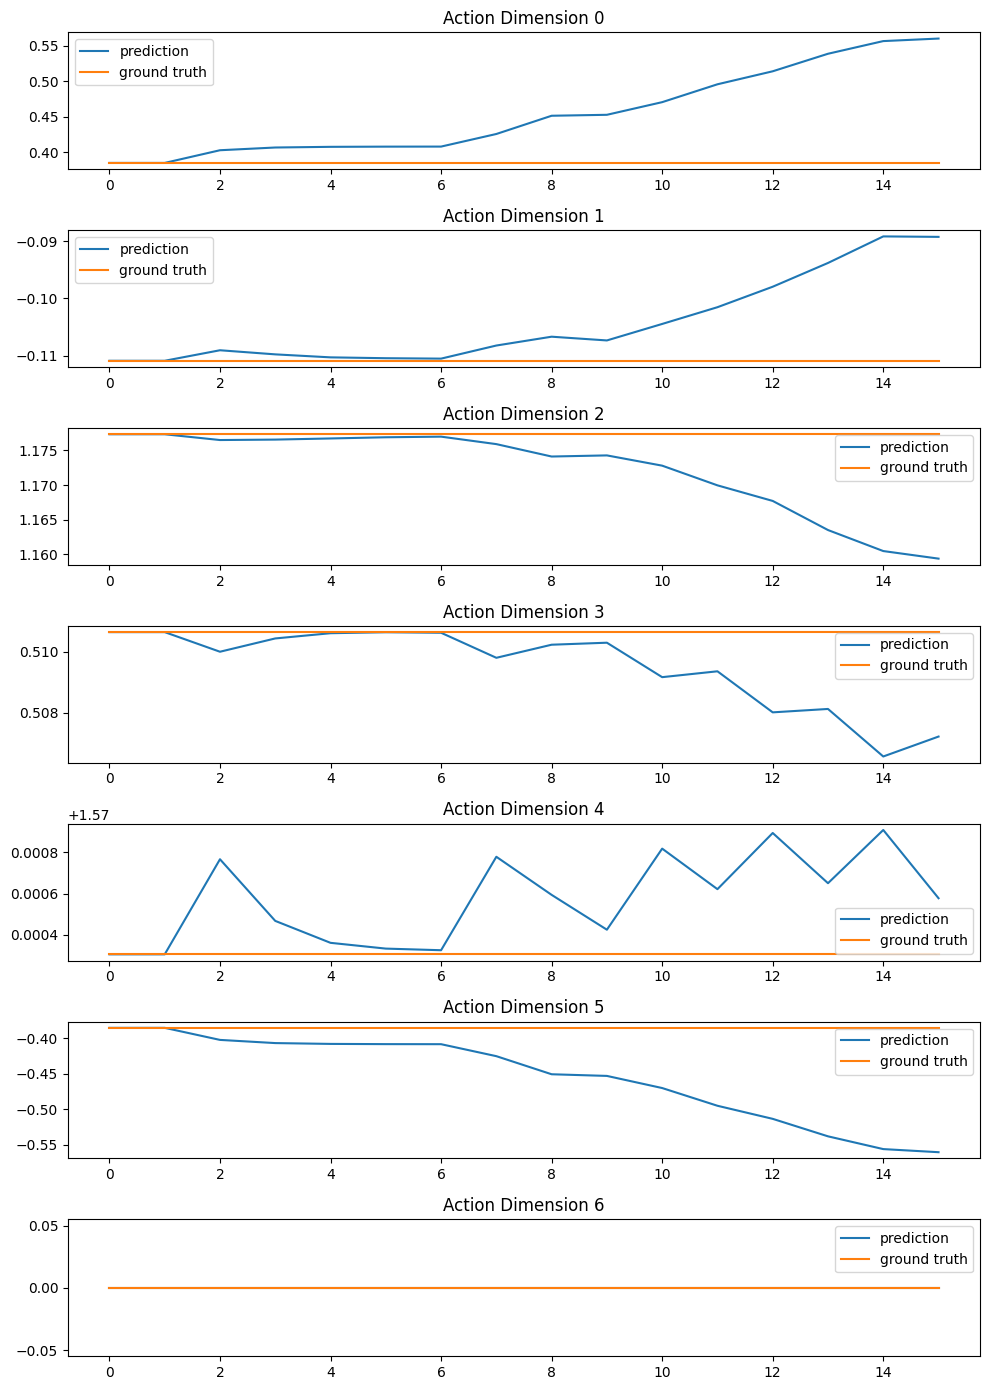

Saved error heatmap to: ./ckpt/diffusion_y/error_heatmap.png


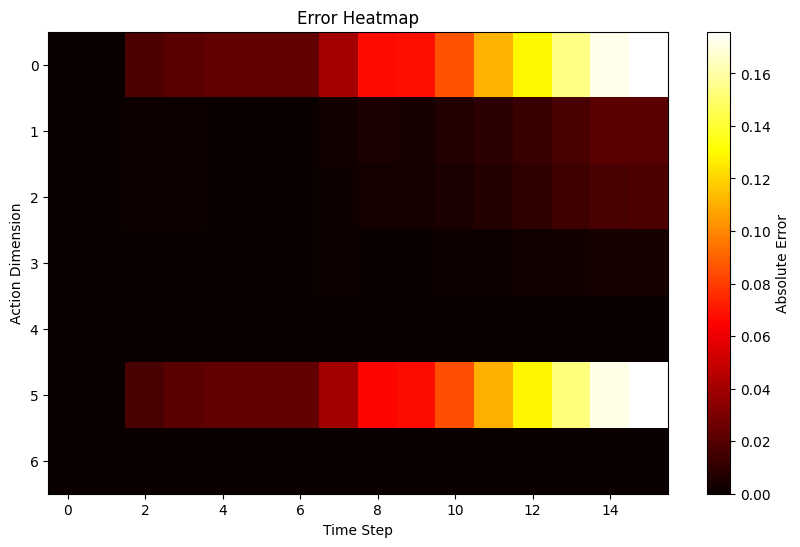

Saved error histogram to: ./ckpt/diffusion_y/error_histogram.png


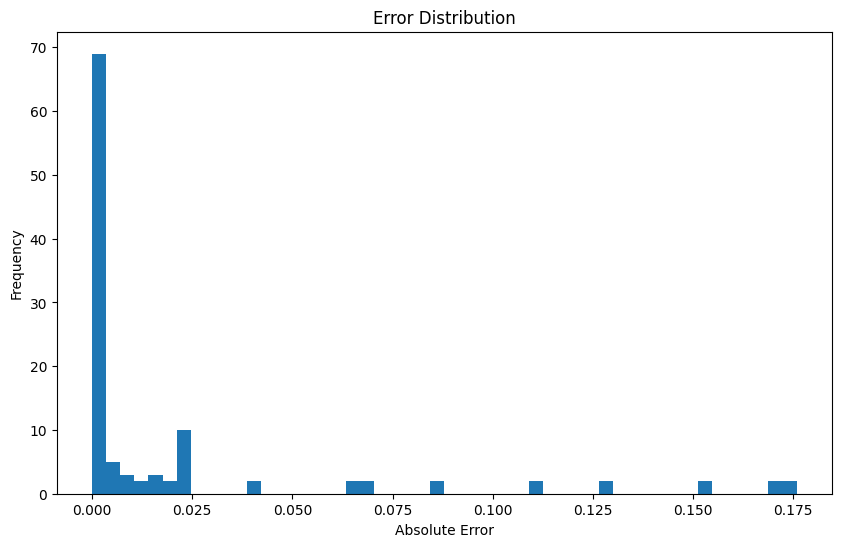

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 저장 디렉토리 확인
save_dir = './ckpt/diffusion_y'
os.makedirs(save_dir, exist_ok=True)
print(f"Saving plots to: {save_dir}")

# 차원 정보 출력
print(f"Action shape before: {action.shape}")
print(f"GT action shape before: {gt_action.shape}")

# 결과를 plot_results와 동일한 형태로 만들기 위해
# 여러 배치의 gt_action과 action을 수집
all_actions = []
all_gt_actions = []

# 현재 배치 추가
all_actions.append(action)
all_gt_actions.append(gt_action)

# 텐서 결합 (여기서는 배치가 하나지만 일관성을 위해)
actions_tensor = torch.cat(all_actions, dim=0)
gt_actions_tensor = torch.cat(all_gt_actions, dim=0)

# 텐서를 numpy로 변환
gt_np = gt_actions_tensor.cpu().detach().numpy()
pred_np = actions_tensor.cpu().detach().numpy()

# 차원 조정 (3차원인 경우 배치와 타임스텝 유지)
if len(pred_np.shape) == 3:
    print(f"Prediction shape is 3D: {pred_np.shape}")
    # train_dp.py에서는 첫 번째 타임스텝만 사용하지만, 
    # 여기서는 모든 타임스텝을 보여주기 위해 배치 차원만 제거
    pred_np = pred_np[0]  # 배치 차원 제거, 결과: (time_steps, action_dim)
    
# gt_np가 2D(batch, action_dim)인 경우 배치 차원 제거
if len(gt_np.shape) == 2:
    gt_np = gt_np[0]  # 배치 차원 제거, 결과: (action_dim,)

print(f"Final shapes for plotting - Pred: {pred_np.shape}, GT: {gt_np.shape}")

# 액션 차원 수와 타임스텝 수 확인
action_dim = gt_np.shape[0]  # gt_np가 1D(action_dim,)이므로 첫 번째 차원이 액션 차원
time_steps = pred_np.shape[0]  # pred_np가 2D(time_steps, action_dim)이므로 첫 번째 차원이 타임스텝 수

# 결과 시각화
fig, axs = plt.subplots(action_dim, 1, figsize=(10, 2*action_dim))

for i in range(action_dim):
    # 여러 개의 서브플롯이 있을 때와 하나만 있을 때를 구분
    if action_dim == 1:
        ax = axs
    else:
        ax = axs[i]
    
    # 예측 액션 (모든 타임스텝)
    pred_action = pred_np[:, i]
    
    # 실제 액션 (단일 값을 모든 타임스텝으로 확장)
    real_action_repeated = np.full(time_steps, gt_np[i])
    
    ax.plot(pred_action, label="prediction")
    ax.plot(real_action_repeated, label="ground truth")
    ax.set_title(f"Action Dimension {i}")
    ax.legend()

plt.tight_layout()
action_plot_path = os.path.join(save_dir, 'action_comparison.png')
plt.savefig(action_plot_path)
print(f"Saved action comparison plot to: {action_plot_path}")
plt.show()
plt.close()

# 에러 히트맵 플롯
error = np.zeros((time_steps, action_dim))
for i in range(action_dim):
    error[:, i] = np.abs(pred_np[:, i] - np.full(time_steps, gt_np[i]))

plt.figure(figsize=(10, 6))
plt.imshow(error.T, aspect='auto', cmap='hot')
plt.colorbar(label='Absolute Error')
plt.xlabel('Time Step')
plt.ylabel('Action Dimension')
plt.title('Error Heatmap')
heatmap_path = os.path.join(save_dir, 'error_heatmap.png')
plt.savefig(heatmap_path)
print(f"Saved error heatmap to: {heatmap_path}")
plt.show()
plt.close()

# 에러 히스토그램 플롯
plt.figure(figsize=(10, 6))
plt.hist(error.flatten(), bins=50)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
histogram_path = os.path.join(save_dir, 'error_histogram.png')
plt.savefig(histogram_path)
print(f"Saved error histogram to: {histogram_path}")
plt.show()
plt.close()